# Проект: классификация

In [468]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder, OrdinalEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [469]:
df = pd.read_csv('bank_fin\\bank_fin.csv', sep = ';')

In [470]:
# Суммарная информация о пропущенных значениях по каждому столбцу
missing_per_column = df.isnull().sum()

# Только столбцы, где есть пропуски
missing_per_column = missing_per_column[missing_per_column > 0]

print(f"Столбцы с пропущенными значениями и их количество: {missing_per_column}")

Столбцы с пропущенными значениями и их количество: balance    25
dtype: int64


### Задание 2

In [471]:
for job in df['job'].unique():
    print(job)

admin.
technician
services
management
retired
blue-collar
unemployed
entrepreneur
housemaid
unknown
self-employed
student


### Задание 3

In [472]:
# Удаляем пробелы, $, и запятые, затем преобразуем к float
df['balance'] = df['balance'].astype(str) \
    .str.replace(' ', '') \
    .str.replace(',', '.') \
    .str.replace('$', '') \
    .astype(float)

# Вычисляем среднее, округляем до 3 знаков
mean_balance = round(df['balance'].mean(), 3)

# Убираем лишние нули
formatted_balance = f"{mean_balance:.3f}".rstrip('0').rstrip('.')

print(f'Среднее значение с округлением до 3 знаков: {formatted_balance}')


Среднее значение с округлением до 3 знаков: 1529.129


### Задание 4

In [473]:
# Преобразуем в числовой тип (ошибки — в NaN)
df['balance'] = pd.to_numeric(df['balance'], errors='coerce')

# Вычисляем медиану
median_balance = df['balance'].median()
print(f"Медианное значение баланса: {median_balance}")

# Заполняем пропуски медианой
df['balance'] = df['balance'].fillna(median_balance)

# Вычисляем среднее значение и округляем до трёх знаков
mean_balance = round(df['balance'].mean(), 3)
print(f"Среднее значение баланса: {mean_balance}")


Медианное значение баланса: 550.0
Среднее значение баланса: 1526.936


### Задание 5

In [474]:
# Для job
job_mode = df.loc[df['job'] != 'unknown', 'job'].mode()[0]
df['job'] = df['job'].replace('unknown', job_mode)

# Для education
education_mode = df.loc[df['education'] != 'unknown', 'education'].mode()[0]
df['education'] = df['education'].replace('unknown', education_mode)

# Выбираем нужных клиентов
popular_clients = df[(df['job'] == job_mode) & (df['education'] == education_mode)]

# Считаем средний баланс, округляем до трёх знаков
mean_balance_popular = round(popular_clients['balance'].mean(), 3)
print(f'Средний баланс популярных клиентов: {mean_balance_popular}')

Средний баланс популярных клиентов: 1598.883


### Задание 6

In [475]:
# 1. Квартиль и IQR
Q1 = df['balance'].quantile(0.25)
Q3 = df['balance'].quantile(0.75)
IQR = Q3 - Q1

# 2. Границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f'Нижняя граница: {lower_bound}')
print(f'Верхняя граница: {upper_bound}')

# 3. Фильтрация — оставим только значения в этих пределах
df = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]

Нижняя граница: -2241.0
Верхняя граница: 4063.0


## Часть 2:  Разведывательный анализ

### Задание 1

deposit
no     5424
yes    4681
Name: count, dtype: int64


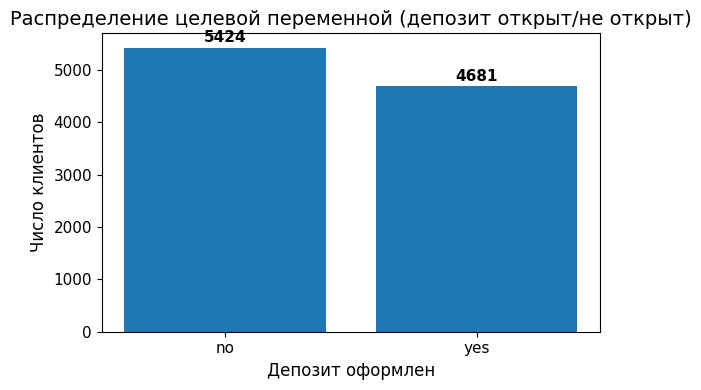

In [476]:
# Частоты по целевой переменной
deposit_counts = df['deposit'].value_counts()
print(deposit_counts)

plt.figure(figsize=(6,4))
bars = plt.bar(deposit_counts.index, deposit_counts.values)
plt.title('Распределение целевой переменной (депозит открыт/не открыт)', fontsize=14)
plt.xlabel('Депозит оформлен', fontsize=12)
plt.ylabel('Число клиентов', fontsize=12)

# Оформим подписи на столбиках
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, int(yval), ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код

### Задания 2 и 3

Максимальный возраст клиента банка: 95
Минимальная продолжительность разговора с клиентом (сек): 2


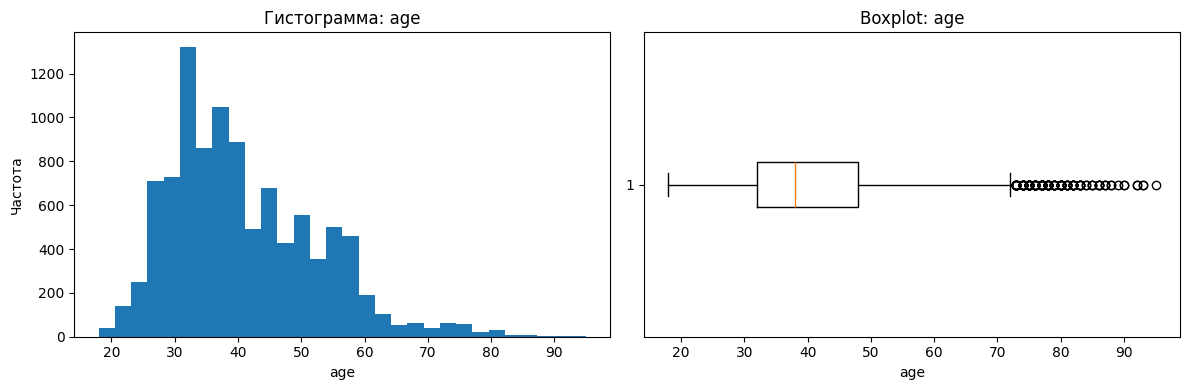

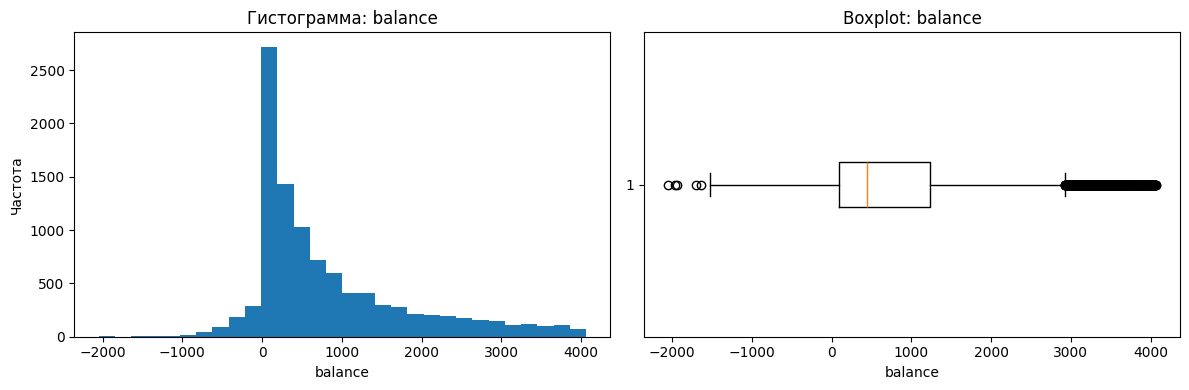

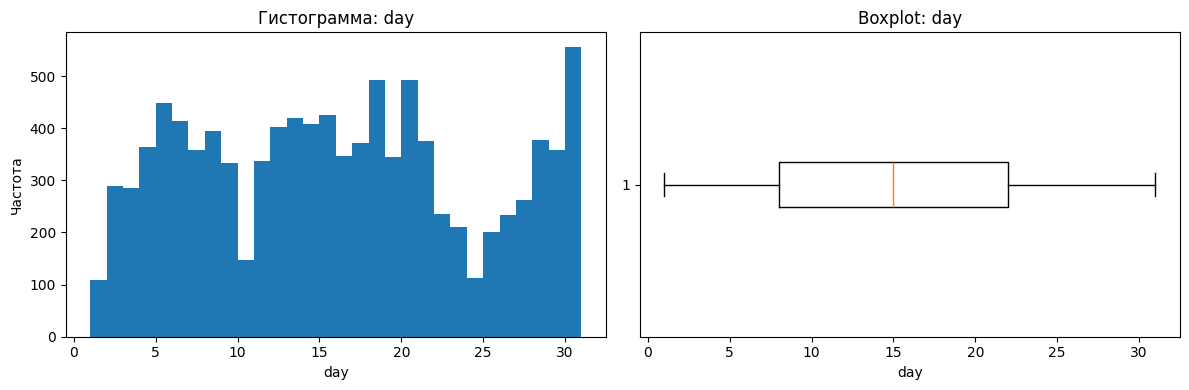

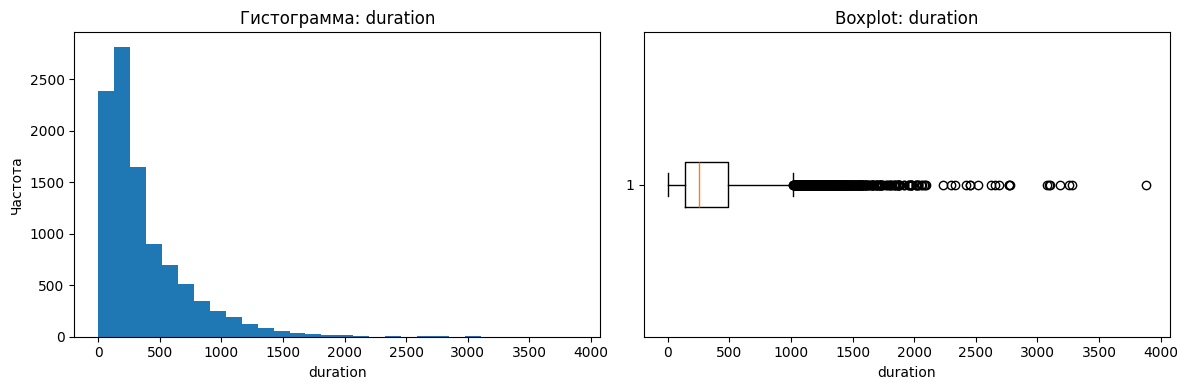

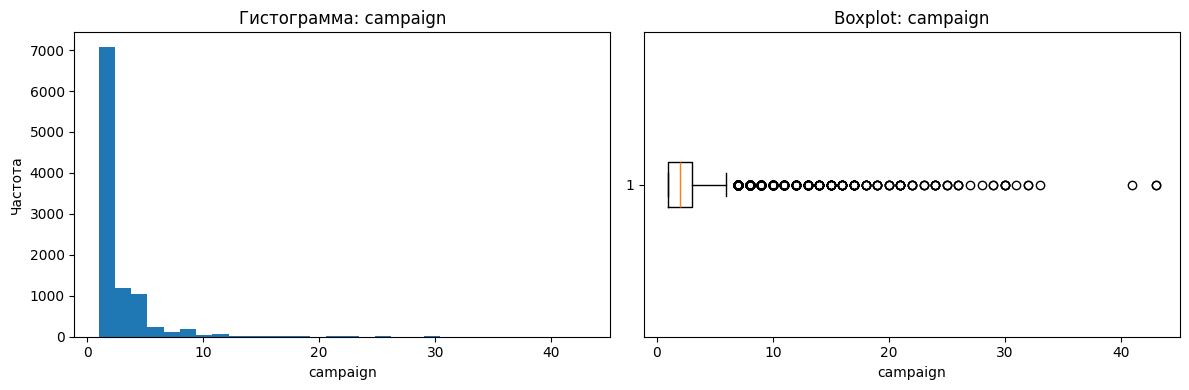

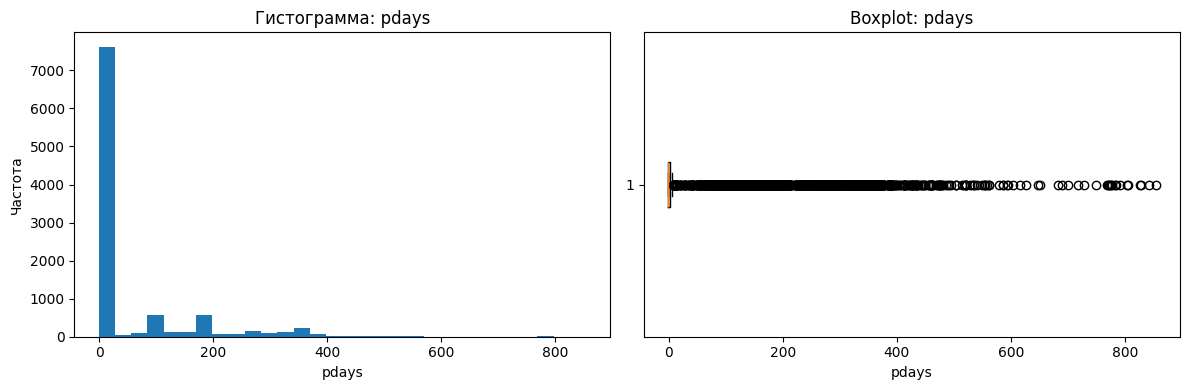

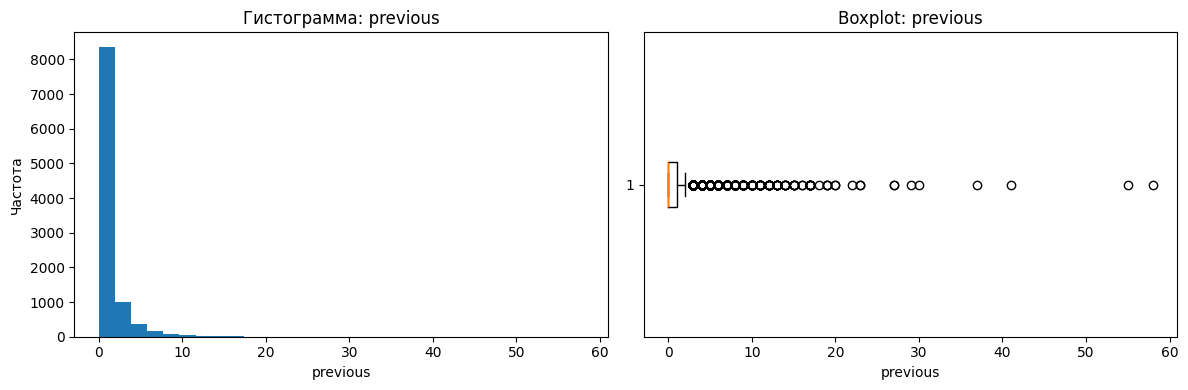

In [477]:
quant_cols = df.select_dtypes(include='number').columns
desc_stats = df[quant_cols].describe().T
desc_stats['range'] = desc_stats['max'] - desc_stats['min']
desc_stats[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'range']]
print('Максимальный возраст клиента банка:', df['age'].max())
print('Минимальная продолжительность разговора с клиентом (сек):', df['duration'].min())



for col in quant_cols:
    plt.figure(figsize=(12,4))
    
    # Гистограмма
    plt.subplot(1,2,1)
    plt.hist(df[col], bins=30)
    plt.title(f'Гистограмма: {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
    
    # Boxplot
    plt.subplot(1,2,2)
    plt.boxplot(df[col], vert=False)
    plt.title(f'Boxplot: {col}')
    plt.xlabel(col)
    
    plt.tight_layout()
    plt.show()


### Задания 4 и 5

Всего сфер занятости: 11
Сферы занятости: ['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'self-employed' 'student']


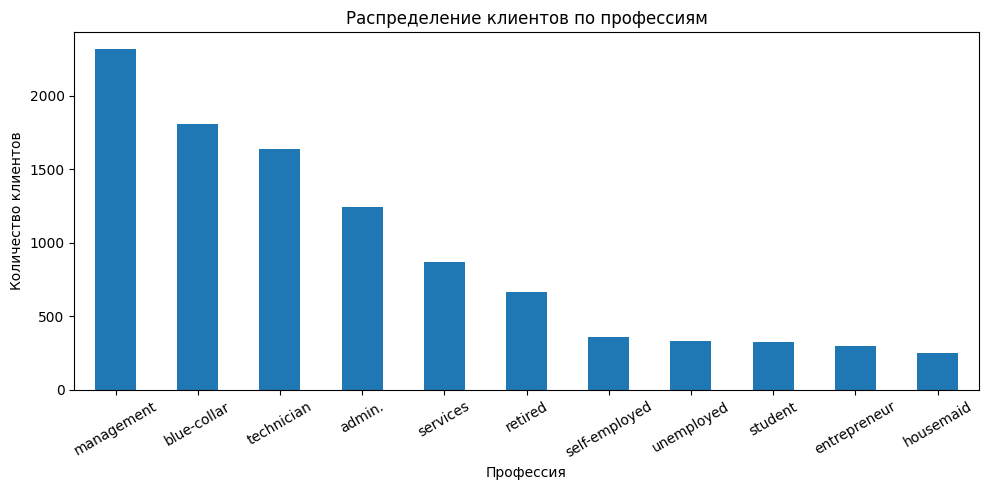

Месяцы, в которые была кампания: ['apr', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep']
Всего месяцев: 12


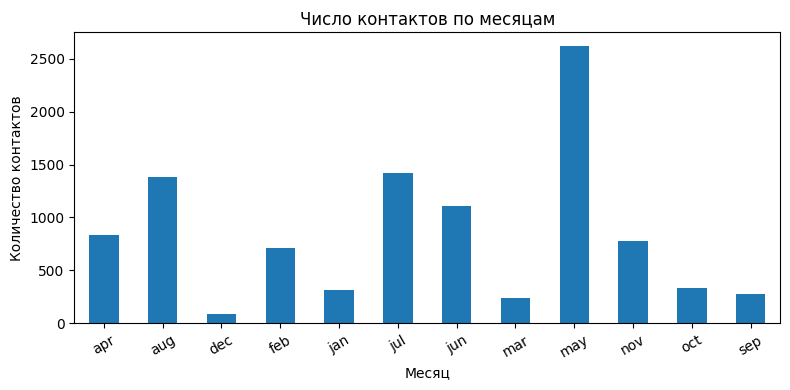

Самое частое семейное положение: married
marital
married     5715
single      3213
divorced    1177
Name: count, dtype: int64


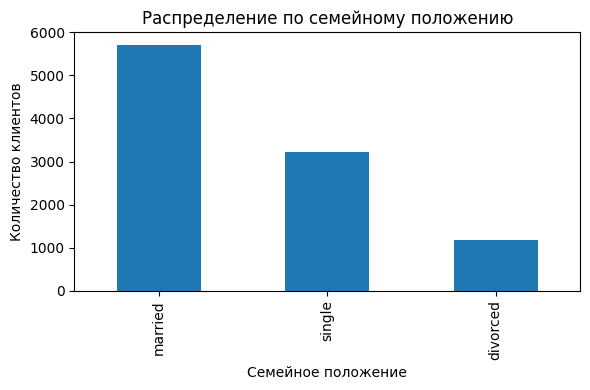

Самый частый уровень образования: secondary
education
secondary    5517
tertiary     3239
primary      1349
Name: count, dtype: int64


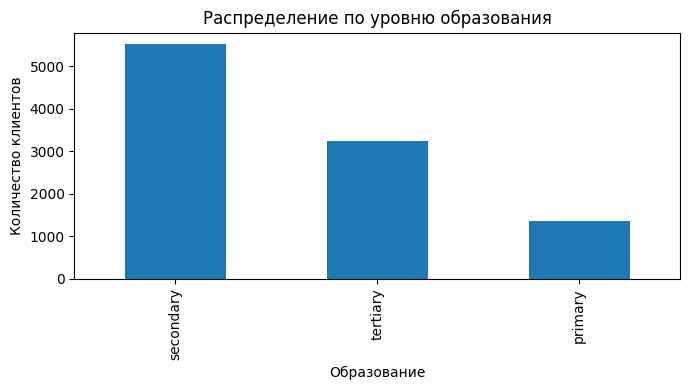

In [478]:
job_unique = df['job'].nunique()
print('Всего сфер занятости:', job_unique)
print('Сферы занятости:', df['job'].unique())

plt.figure(figsize=(10,5))
df['job'].value_counts().plot(kind='bar')
plt.title('Распределение клиентов по профессиям')
plt.xlabel('Профессия')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

months = df['month'].unique()
print('Месяцы, в которые была кампания:', sorted(months))
print('Всего месяцев:', len(months))

plt.figure(figsize=(8,4))
df['month'].value_counts().loc[sorted(df['month'].unique())].plot(kind='bar')
plt.title('Число контактов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество контактов')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

marital_mode = df['marital'].mode()[0]
print('Самое частое семейное положение:', marital_mode)
print(df['marital'].value_counts())

plt.figure(figsize=(6,4))
df['marital'].value_counts().plot(kind='bar')
plt.title('Распределение по семейному положению')
plt.xlabel('Семейное положение')
plt.ylabel('Количество клиентов')
plt.tight_layout()
plt.show()

education_mode = df['education'].mode()[0]
print('Самый частый уровень образования:', education_mode)
print(df['education'].value_counts())

plt.figure(figsize=(7,4))
df['education'].value_counts().plot(kind='bar')
plt.title('Распределение по уровню образования')
plt.xlabel('Образование')
plt.ylabel('Количество клиентов')
plt.tight_layout()
plt.show()
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

### Задание 6

deposit     no   yes
poutcome            
failure    562   547
other      216   265
success     84   861
unknown   4562  3008
Статусы, где успехов больше, чем неудач:
deposit    no  yes
poutcome          
other     216  265
success    84  861


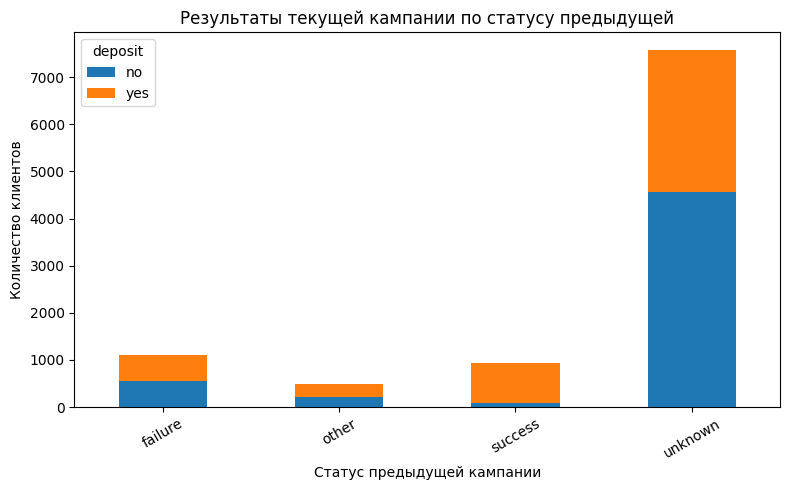

Таблица сопряжённости:
 deposit     no   yes
poutcome            
failure    562   547
other      216   265
success     84   861
unknown   4562  3008 

Статусы предыдущей кампании, где успехов больше, чем неудач:
deposit    no  yes
poutcome          
other     216  265
success    84  861


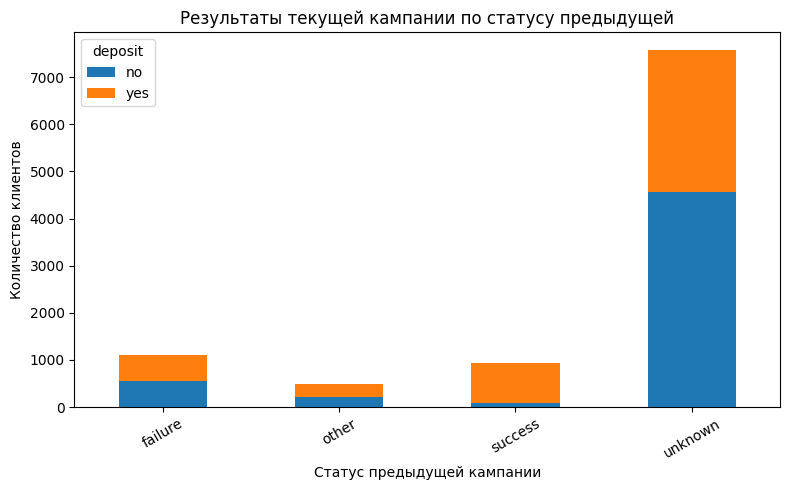

In [479]:
pivot = pd.crosstab(df['poutcome'], df['deposit'])
print(pivot)

# Где успехов больше, чем неудач?
success_poutcome = pivot[pivot['yes'] > pivot['no']]
print('Статусы, где успехов больше, чем неудач:')
print(success_poutcome)

pivot.plot(kind='bar', stacked=True, figsize=(8,5))
plt.title('Результаты текущей кампании по статусу предыдущей')
plt.xlabel('Статус предыдущей кампании')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Кросстаблица: poutcome vs deposit
pivot = pd.crosstab(df['poutcome'], df['deposit'])
print('Таблица сопряжённости:\n', pivot, '\n')

# Находим статусы, где успехов ("yes") больше, чем неудач ("no")
success_poutcome = pivot[pivot['yes'] > pivot['no']]
print('Статусы предыдущей кампании, где успехов больше, чем неудач:')
print(success_poutcome)

pivot.plot(kind='bar', stacked=True, figsize=(8,5))
plt.title('Результаты текущей кампании по статусу предыдущей')
plt.xlabel('Статус предыдущей кампании')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код

### Задание 7

In [480]:
# Группируем по месяцам и считаем общее количество "no" и общее количество контактов
month_stats = df.groupby('month')['deposit'].value_counts(normalize=True).unstack().fillna(0)

# Берём только процент неудач (значение "no")
month_stats_no = month_stats['no']

# Находим месяц с максимальным процентом неудач
worst_month = month_stats_no.idxmax()
max_percent = month_stats_no.max()

print(f'В месяц {worst_month} самый большой процент неудач: {max_percent:.2%}')


В месяц may самый большой процент неудач: 67.86%


### Задание 8

age_group
30-40    3961
40-50    2382
50-60    1654
<30      1455
60+       653
Name: count, dtype: int64


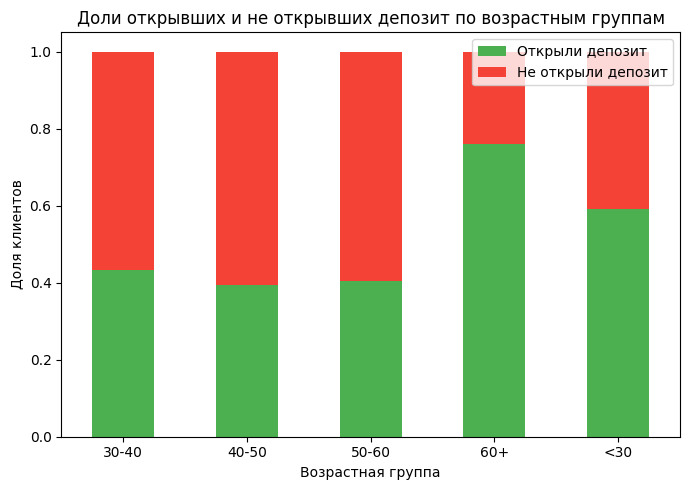

In [481]:
# Функция для категоризации возраста
def age_group(age):
    if age < 30:
        return '<30'
    elif 30 <= age < 40:
        return '30-40'
    elif 40 <= age < 50:
        return '40-50'
    elif 50 <= age < 60:
        return '50-60'
    else:
        return '60+'

# Создаём новый столбец 'age_group'
df['age_group'] = df['age'].apply(age_group)

# Посмотрим на распределение по возрастным категориям
print(df['age_group'].value_counts())
# Подсчёт по возрастным группам и целевой переменной
age_deposit = df.groupby('age_group')['deposit'].value_counts(normalize=True).unstack().fillna(0)

# Построение stacked barplot
age_deposit[['yes', 'no']].plot(kind='bar', stacked=True, figsize=(7,5), color=['#4caf50', '#f44336'])
plt.title('Доли открывших и не открывших депозит по возрастным группам')
plt.xlabel('Возрастная группа')
plt.ylabel('Доля клиентов')
plt.legend(['Открыли депозит', 'Не открыли депозит'])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()




### Задания 9 и 10

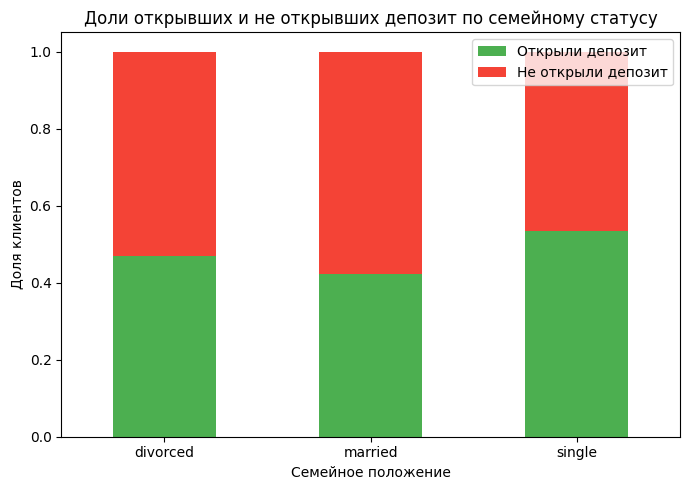

In [482]:
# Считаем доли для каждого семейного положения и факта открытия депозита
marital_deposit = df.groupby('marital')['deposit'].value_counts(normalize=True).unstack().fillna(0)

# Столбчатая диаграмма с накоплением (относительные доли)
marital_deposit[['yes', 'no']].plot(kind='bar', stacked=True, figsize=(7,5), color=['#4caf50', '#f44336'])
plt.title('Доли открывших и не открывших депозит по семейному статусу')
plt.xlabel('Семейное положение')
plt.ylabel('Доля клиентов')
plt.legend(['Открыли депозит', 'Не открыли депозит'])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

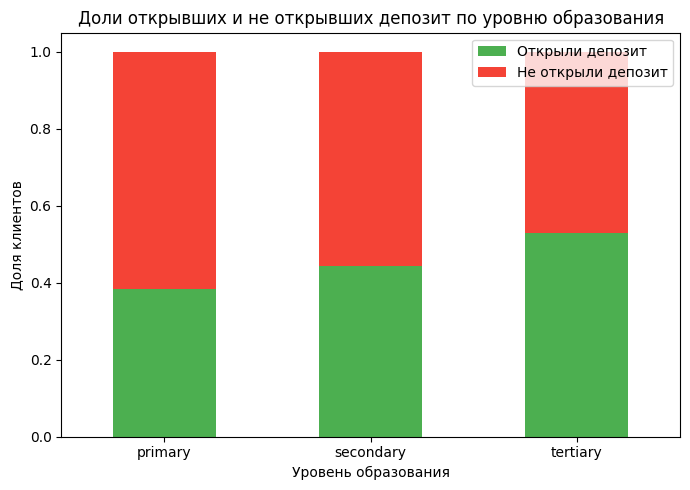

In [483]:

# Группировка по образованию и целевой переменной (относительные доли)
education_deposit = df.groupby('education')['deposit'].value_counts(normalize=True).unstack().fillna(0)

# Визуализация
education_deposit[['yes', 'no']].plot(kind='bar', stacked=True, figsize=(7,5), color=['#4caf50', '#f44336'])
plt.title('Доли открывших и не открывших депозит по уровню образования')
plt.xlabel('Уровень образования')
plt.ylabel('Доля клиентов')
plt.legend(['Открыли депозит', 'Не открыли депозит'])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


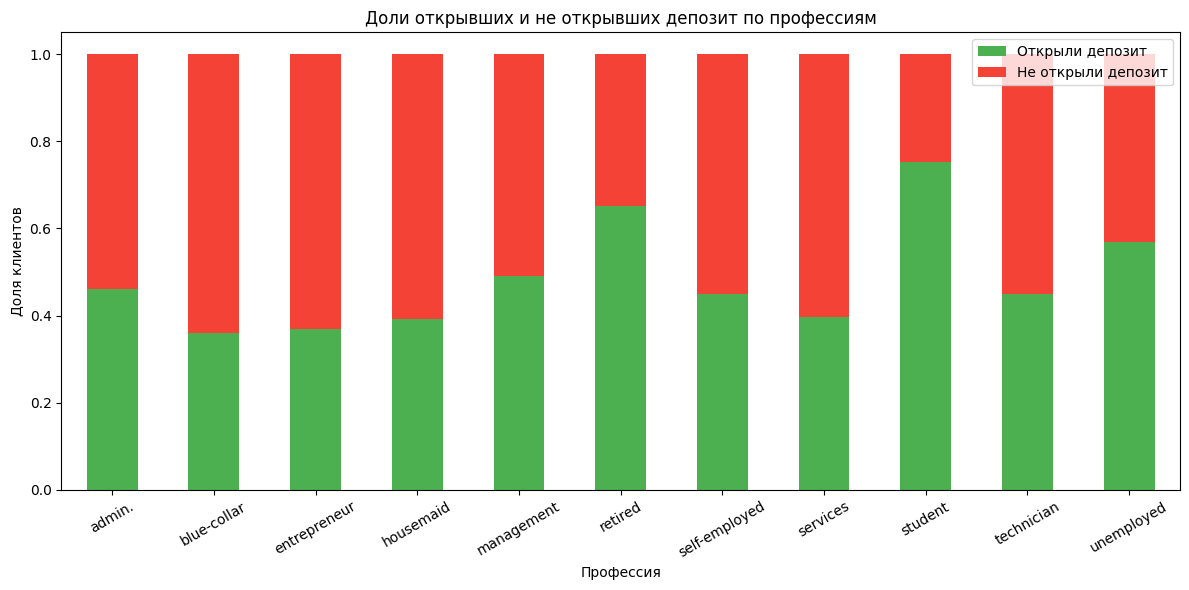

Сфера с наибольшим числом клиентов: management
Сфера с наибольшим числом клиентов: management (2315 клиентов)


In [484]:

# Доли по профессиям и факту открытия депозита
job_deposit = df.groupby('job')['deposit'].value_counts(normalize=True).unstack().fillna(0)

# Построение stacked barplot
job_deposit[['yes', 'no']].plot(kind='bar', stacked=True, figsize=(12,6), color=['#4caf50', '#f44336'])
plt.title('Доли открывших и не открывших депозит по профессиям')
plt.xlabel('Профессия')
plt.ylabel('Доля клиентов')
plt.legend(['Открыли депозит', 'Не открыли депозит'])
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

most_common_job = df['job'].mode()[0]
print('Сфера с наибольшим числом клиентов:', most_common_job)
count = df['job'].value_counts()[most_common_job]
print(f'Сфера с наибольшим числом клиентов: {most_common_job} ({count} клиентов)')


### Задание 11

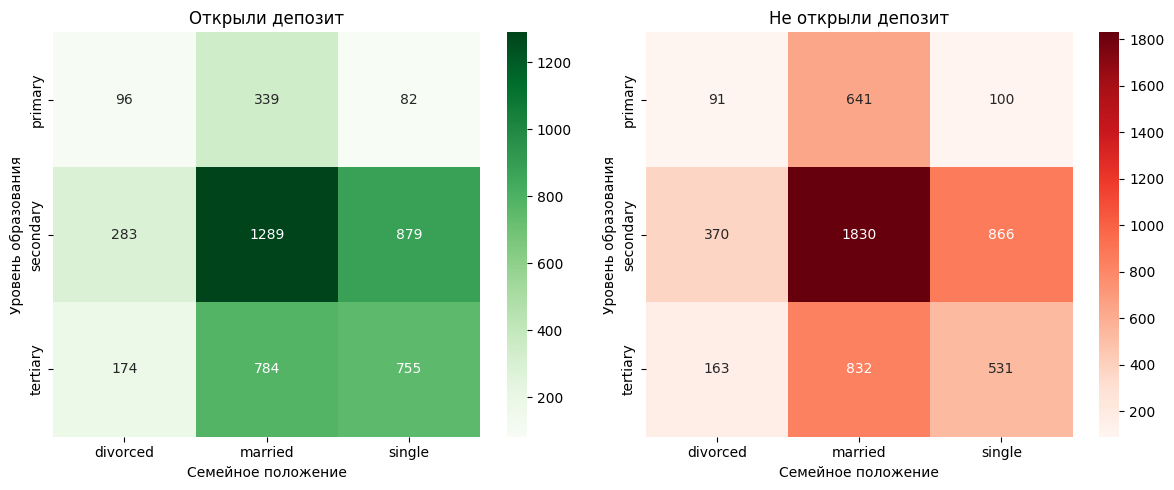

Сводная таблица — Открыли депозит:
marital    divorced  married  single
education                           
primary          96      339      82
secondary       283     1289     879
tertiary        174      784     755

Сводная таблица — Не открыли депозит:
marital    divorced  married  single
education                           
primary          91      641     100
secondary       370     1830     866
tertiary        163      832     531


In [485]:
# 1. Разделение данных
df_yes = df[df['deposit'] == 'yes']
df_no = df[df['deposit'] == 'no']

# 2. Сводные таблицы
pivot_yes = pd.crosstab(df_yes['education'], df_yes['marital'])
pivot_no = pd.crosstab(df_no['education'], df_no['marital'])

# 3. Построение тепловых карт
plt.figure(figsize=(12, 5))

# Тепловая карта для открывших депозит
plt.subplot(1, 2, 1)
sns.heatmap(pivot_yes, annot=True, fmt='d', cmap='Greens')
plt.title('Открыли депозит')
plt.xlabel('Семейное положение')
plt.ylabel('Уровень образования')

# Тепловая карта для неоткрывших депозит
plt.subplot(1, 2, 2)
sns.heatmap(pivot_no, annot=True, fmt='d', cmap='Reds')
plt.title('Не открыли депозит')
plt.xlabel('Семейное положение')
plt.ylabel('Уровень образования')

plt.tight_layout()
plt.show()

# 4. Вывод сводных таблиц
print("Сводная таблица — Открыли депозит:")
print(pivot_yes)
print("\nСводная таблица — Не открыли депозит:")
print(pivot_no)

## Часть 3: преобразование данных

### Задание 1

In [486]:
le_edu = LabelEncoder()
df['education'] = le_edu.fit_transform(df['education'])
print('Сумма закодированных значений education:', df['education'].sum())
le_age = LabelEncoder()
df['age_group'] = le_age.fit_transform(df['age_group'])
print('Сумма закодированных значений age_group:', df['age_group'].sum())

Сумма закодированных значений education: 11995
Сумма закодированных значений age_group: 13469


### Задания 2 и 3

In [487]:
df['deposit'] = df['deposit'].map({'yes': 1, 'no': 0})
df['default'] = df['default'].map({'yes': 1, 'no': 0})
df['housing'] = df['housing'].map({'yes': 1, 'no': 0})
df['loan'] = df['loan'].map({'yes': 1, 'no': 0})


std_deposit = round(df['deposit'].std(), 3)
print(f'Стандартное отклонение: {std_deposit}')

default_mean = df['default'].mean()
housing_mean = df['housing'].mean()
loan_mean = df['loan'].mean()

result = round(default_mean + housing_mean + loan_mean, 3)
print(f'Сумма средних: {result}')



Стандартное отклонение: 0.499
Сумма средних: 0.635


### Задание 4

In [488]:
nominal_cols = ['job', 'marital', 'contact', 'month', 'poutcome']

# Создаём dummy-переменные и объединяем их с исходным датафреймом
df = pd.concat([df, pd.get_dummies(df[nominal_cols], prefix=nominal_cols, drop_first=False)], axis=1)

# Проверим, что признаки добавились:
print(df.columns[-20:])  # Показываем последние 20 столбцов для примера

n_features = df.shape[1] - 1  # Всего столбцов минус столбец deposit
print('Количество признаков:', n_features)
df.drop(columns=nominal_cols, inplace=True)
df = df.drop('age', axis=1)

a_features = df.shape[1] - 1 
print('Количество признаков:', a_features)
print(df)


Index(['marital_single', 'contact_cellular', 'contact_telephone',
       'contact_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_feb',
       'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'poutcome_failure',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown'],
      dtype='object')
Количество признаков: 50
Количество признаков: 44
       education  default  balance  housing  loan  day  duration  campaign  \
0              1        0   2343.0        1     0    5      1042         1   
1              1        0     45.0        0     0    5      1467         1   
2              1        0   1270.0        1     0    5      1389         1   
3              1        0   2476.0        1     0    5       579         1   
4              2        0    184.0        0     0    5       673         2   
...          ...      ...      ...      ...   ...  ...       ...       ...   
11157          0        0      1.0

### Задания 5 и 6

In [489]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# corr_matrix = df.corr(numeric_only=True)

# plt.figure(figsize=(14, 10))
# sns.heatmap(corr_matrix, cmap='coolwarm')
# plt.title('Корреляционная тепловая карта')
# plt.tight_layout()
# plt.show()

# # Столбчатая диаграмма для связи с целевой переменной
# target_corr = corr_matrix['deposit'].drop('deposit').sort_values(ascending=False)
# target_corr.plot(kind='bar', figsize=(8, 6))
# plt.title('Корреляция признаков с целевой переменной')
# plt.ylabel('Коэффициент корреляции с deposit')
# plt.tight_layout()
# plt.show()

# # Получаем корреляции с целевой переменной
# target_corr = df.corr(numeric_only=True)['deposit'].drop('deposit')

# # Сортируем по убыванию абсолютного значения корреляции
# sorted_corr = target_corr.abs().sort_values(ascending=False)

# # Теперь выведем признаки по убыванию силы взаимосвязи
# print(sorted_corr)

# # Корреляционная матрица только по признакам (без целевой переменной)
# feature_corr = df.drop(columns=['deposit']).corr(numeric_only=True)



### Задания 7 и 8

In [490]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
cols = ['balance'] + [col for col in X.columns if col != 'balance']
X = X[cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
print(X_test)

       balance  education  default  housing  loan  day  duration  campaign  \
3333     155.0          0        0        0     0   12       290         1   
6048     512.0          1        0        0     0   28        70         1   
5675    1403.0          1        0        0     0   11       214         8   
2564    1270.0          2        0        0     0   19       232         3   
8983    1074.0          2        0        1     0   15       523         2   
...        ...        ...      ...      ...   ...  ...       ...       ...   
1730     507.0          1        0        0     0   30       380         1   
9672     443.0          0        0        0     0   30        10         1   
8584    -311.0          1        0        1     0    6        55         2   
10972    250.0          1        0        0     1   29       133         1   
3818     205.0          1        0        0     0    4       180         1   

       pdays  previous  ...  month_jun  month_mar  month_may  m

In [491]:
print('Размер тестовой выборки:', len(X_test))
mean_target_test = round(y_test.mean(), 2)
print(f'Среднее значение целевой переменной в тестовой выборке: {mean_target_test}')


Размер тестовой выборки: 3335
Среднее значение целевой переменной в тестовой выборке: 0.46


### Задание 9

In [452]:

selector = SelectKBest(score_func=f_classif, k=15)
selector.fit_transform(X_train, y_train)

best_indices = selector.get_support(indices=True)
best_features = X_train.columns[best_indices]

print('Топ-15 лучших признаков:')
for f in best_features:
    print(f)

Топ-15 лучших признаков:
balance
housing
duration
campaign
pdays
previous
age_group
contact_cellular
contact_unknown
month_mar
month_may
month_oct
month_sep
poutcome_success
poutcome_unknown


### Задание 10

In [501]:
from sklearn.preprocessing import MinMaxScaler
# Оставляем только числовые признаки
X_train_selected = X_train[best_features]
X_test_selected = X_test[best_features]

# Создаём scaler и обучаем только на обучающих данных!
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Если нужен DataFrame c теми же именами столбцов:
import pandas as pd
X_train_scaled = pd.DataFrame(X_train_scaled, columns=best_features, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=best_features, index=X_test.index)

print(X_train_scaled.head())
print(X_test_scaled.head())

first_pred_mean = round(X_test_scaled.iloc[:, 0].mean(), 2)
print(f'Среднее значение первого предиктора в тестовой выборке: {first_pred_mean}')



       balance  housing  duration  campaign     pdays  previous  age_group  \
7287  0.426374      1.0  0.131735   0.00000  0.000000  0.000000        0.0   
4766  0.346531      0.0  0.075793   0.00000  0.240936  0.034483        0.0   
5712  0.335242      1.0  0.102346   0.02381  0.419883  0.086207        0.0   
2530  0.407886      0.0  0.034803   0.00000  0.120468  0.086207        0.0   
9294  0.571499      0.0  0.025264   0.00000  0.138012  0.137931        0.0   

      contact_cellular  contact_unknown  month_mar  month_may  month_oct  \
7287               1.0              0.0        0.0        0.0        0.0   
4766               1.0              0.0        0.0        0.0        0.0   
5712               0.0              0.0        0.0        1.0        0.0   
2530               1.0              0.0        0.0        0.0        0.0   
9294               1.0              0.0        0.0        0.0        0.0   

      month_sep  poutcome_success  poutcome_unknown  
7287        0.0     

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [505]:
X_train_num = X_train.select_dtypes(include='number')
X_test_num = X_test.select_dtypes(include='number')

# Масштабируем
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled = scaler.transform(X_test_num)

# Обучаем модель
logreg = LogisticRegression(solver='sag', random_state=42, max_iter=1000)
logreg.fit(X_train_scaled, y_train)

# Предсказываем и считаем accuracy
y_pred = logreg.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f'{accuracy:.2f}') 

0.77


### Задания 2,3,4

              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1790
           1       0.74      0.71      0.72      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.74      0.75      3335
weighted avg       0.75      0.75      0.75      3335

0.75


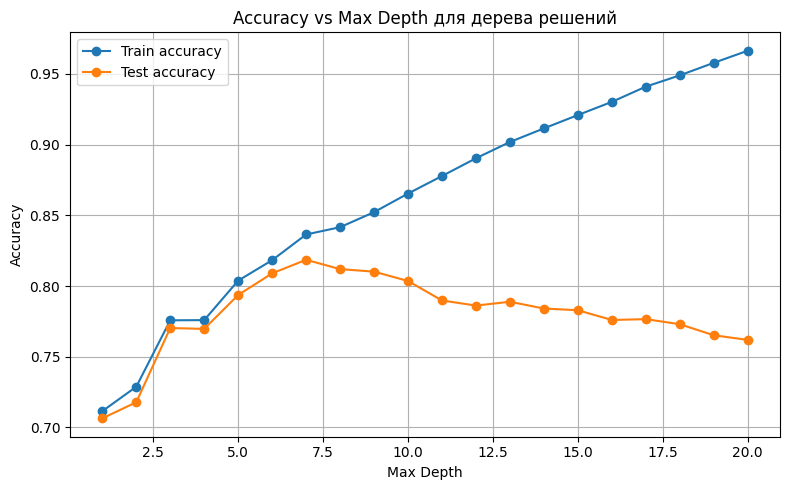

Максимальная accuracy на тесте: 0.82 при глубине: [7]


In [496]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Инициализация и обучение
tree = DecisionTreeClassifier(criterion='entropy', random_state=42)
tree.fit(X_train_scaled, y_train)

# Предсказание на тестовой выборке
y_pred_tree = tree.predict(X_test_scaled)
print(classification_report(y_test, y_pred_tree))
# Оценка accuracy
tree_accuracy = accuracy_score(y_test, y_pred_tree)
print(round(tree_accuracy, 2))

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

train_accuracies = []
test_accuracies = []
max_depths = range(1, 21)  # Можно увеличить диапазон при необходимости

for depth in max_depths:
    tree = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=depth)
    tree.fit(X_train_scaled, y_train)
    y_pred_train = tree.predict(X_train_scaled)
    y_pred_test = tree.predict(X_test_scaled)
    train_accuracies.append(accuracy_score(y_train, y_pred_train))
    test_accuracies.append(accuracy_score(y_test, y_pred_test))

plt.figure(figsize=(8,5))
plt.plot(max_depths, train_accuracies, label='Train accuracy', marker='o')
plt.plot(max_depths, test_accuracies, label='Test accuracy', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth для дерева решений')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Найдём глубину, при которой test accuracy максимальна
best_test_acc = max(test_accuracies)
best_depths = [depth for depth, acc in zip(max_depths, test_accuracies) if acc == best_test_acc]

print(f'Максимальная accuracy на тесте: {best_test_acc:.2f} при глубине: {best_depths}')


### Задание 5

In [460]:

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Сетка параметров
param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth': [3, 5, 7]
}

# Модель
tree = DecisionTreeClassifier(criterion='entropy', random_state=42)

# GridSearch с кросс-валидацией (например, 5-fold)
grid_search = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

print('Лучшие параметры:', grid_search.best_params_)
print('Лучшее значение accuracy (кросс-валидация):', round(grid_search.best_score_, 3))

# Если хочешь применить лучшую модель к тестовой выборке:
best_tree = grid_search.best_estimator_
test_accuracy = best_tree.score(X_test_scaled, y_test)
print('Accuracy на тестовой выборке для оптимальных параметров:', round(test_accuracy, 3))

# accuracy на тестовой выборке для лучшей модели после GridSearch
test_accuracy = best_tree.score(X_test_scaled, y_test)
print(round(test_accuracy, 2))




Лучшие параметры: {'max_depth': 5, 'min_samples_split': 5}
Лучшее значение accuracy (кросс-валидация): 0.804
Accuracy на тестовой выборке для оптимальных параметров: 0.793
0.79


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [303]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score

# Обучаем случайный лес с указанными параметрами
rf = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
rf.fit(X_train_scaled, y_train)

# Предсказания
y_pred_rf = rf.predict(X_test_scaled)

# Accuracy
rf_accuracy = round(accuracy_score(y_test, y_pred_rf), 2)
print('Accuracy:', rf_accuracy)

# Recall (по классу "1" — открытие депозита)
rf_recall = round(recall_score(y_test, y_pred_rf), 2)
print('Recall:', rf_recall)


Accuracy: 0.82
Recall: 0.83


### Задания 2 и 3

In [298]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

# Обучаем модель с указанными параметрами
gb = GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_scaled, y_train)

# Предсказания
y_pred_gb = gb.predict(X_test_scaled)

# F1-метрика
gb_f1 = round(f1_score(y_test, y_pred_gb), 2)
print('F1:', gb_f1)


F1: 0.81


### Задание 4

In [299]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score

# Базовые алгоритмы
estimators = [
    ('tree', DecisionTreeClassifier(criterion='entropy', random_state=42)),
    ('logreg', LogisticRegression(solver='sag', random_state=42, max_iter=1000)),
    ('gb', GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
    ))
]

# Мета-модель
final_estimator = LogisticRegression(solver='sag', random_state=42, max_iter=1000)

# Стекинг
stacking = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    n_jobs=-1
)

stacking.fit(X_train_scaled, y_train)
y_pred_stack = stacking.predict(X_test_scaled)

# Precision на тестовой выборке
stack_precision = round(precision_score(y_test, y_pred_stack), 2)
print('Precision:', stack_precision)


Precision: 0.8


### Задание 5

In [301]:
import pandas as pd
import numpy as np

# Получаем важности и имена признаков
importances = rf.feature_importances_
feature_names = X_train_scaled.columns

# Соберём в DataFrame
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp = feat_imp.sort_values(by='importance', ascending=False)

# Топ-3
top3 = feat_imp
print(top3)


              feature  importance
5            duration    0.546247
7               pdays    0.092233
1             balance    0.074770
2             housing    0.069321
10  age_group_encoded    0.059526
4                 day    0.053103
8            previous    0.042126
6            campaign    0.030861
9   education_encoded    0.017627
3                loan    0.013325
0             default    0.000861


### Задания 6,7,8

In [302]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )
    clf.fit(X_train_scaled, y_train)
    preds = clf.predict(X_test_scaled)
    return accuracy_score(y_test, preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)  # Можно увеличить число попыток

print('Лучшие параметры:', study.best_params)
print('Лучшее accuracy на тестовой выборке:', round(study.best_value, 2))


ModuleNotFoundError: No module named 'optuna'